# Mining performance HotSpots with JProfiler, jQAssistant, Neo4j and Pandas

# Claim

We don't need more tools that show use more problems in our software. We need ways to determine the right problem to solve. But often we just fix the symptoms on the surface rather then the underlying problems. I find that approach non-professional and want to do my part to improve this situation by delivering root cause analysis of symptoms to get to the real problem.

# Introduction
In this notebook, I'll show you one of my approaches of mining performance problems based on application runtime performance analysis. One could use such an analysis to make the point that there are severe design errors that have negative influence on the application's overall performance.

The key idea is to use graph analysis to analyze call stacks that were created by a performance profiling tool. With this approach I not only want to show **"the fact"** that is causing a performance issue (because this fact shows that something takes long to execute or is executed too many times), but also the reasons behing that fact. I try to do this by extracting various additional information like the application's **entry points**, the **trigger** within the application causing the fact and the **immediate reason** that calls the fact. This is a very powerful approach to determine the most critical parts in the application and gives you a point where you could start improving.

# Relevance
I use this analysis at work to determine the biggest performance bottleneck in a big application (> 500k LOCs). We then work out possible improvements for that specific hotspot, create a prototypical fix for it, measure the fix's impact and convince with these numbers that we need some money to fix the problem appication wide (and work on the next performance bottleneck and so on). Apart from that, this graph analysis approach where you pick out only the interesting parts it in general very useful.

I hope you'll see that this is a very reasonable approach albeit the simplified use case that I show in this notebook.

# Profiling with JProfiler
As a prerequisit for this analysis, we need performance profiling data gathered by a profiler or an Application Performance Management tool. In my case, I run a performance test with JMeter for a [fork of the Spring sample project PetClinic](https://buschmais.github.io/spring-petclinic/) and use [JProfiler](http://www.ej-technologies.com/products/jprofiler/overview.html) to record some performance measures while the test was running.  

<p><tt>&lt;advertisment&gt;</tt><br />
JProfiler is a great commercial tool and costs around 400 €. It really worth the money because it gives you deep insights how your application performs under the hood. At this point, I want to thank ej-technologies for giving me with a [free open-source license](https://www.ej-technologies.com/buy/jprofiler/openSource) for JProfiler that enables this blog post in exchange of mentioning their product:

<a href="http://www.ej-technologies.com/products/jprofiler/overview.html">
![](https://www.ej-technologies.com/images/product_banners/jprofiler_large.png)</a>
<tt>&lt;/advertisment&gt;</tt>
</p>

Also outside the advertisement block, I personally like JProfiler a lot because it does what it does very very good.

So, what we need for this analysis is a recorded runtime stack of all method calls as a call tree. A call tree shows you a tree of the called methods. Some tools do this on a pre-requeset basis (like XRebel, StageMonitor, InspectIT or DynaTrace) or for the time of the recording (like JProfiler or YourKit). So below, you can see the call tree for the called methods with their measured CPU wall clock time (aka the real time that is spent in that method) for a complete test run:

![](resources/jprofiler_cpu_call_tree.png)

It shows you the call hierarchy from entry point into an application to the last called method (the "leafs") as well as the time in that method ("self-time") and the number of invocations:

![](resources/jprofiler_cpu_call_tree_leaf.png)

With such a view, you see which parts of your application call which classes and methods by drilling down the hierarchy. But there is more: You can also "turn around" the call tree and listen all the so called "HotSpots". Technically, e. g. for CPU HotSpots, JProfiler sums up all the measurements for the method call leafs that take longer than 0.1% of all method calls:

![](resources/jprofiler_cpu_hot_spots.png)

These views are also available for other measures like web service calls, file accesses or DB calls, that is shown below:

![](resources/jprofiler_jdbc_hot_spots.png)

In the JProfiler GUI (or the command line tool jpexport), you can export such a call tree into a XML file. And this is were our journey begins.

# Reading XML into Neo4j

If you export the HotSpots of some measures (incl. the complete call tree) with JProfiler, you'll get a XML file like the following:

In [1]:
with open (r'data/spring-petclinic/JDBC_Probe_Hot_Spots_jdbc.xml') as log:
    [print(line[:70] + "...") for line in log.readlines()[:10]]

<?xml version="1.0" encoding="UTF-8"?>
...
<tree type="Probe Hot Spots" probe="JDBC" threadSelection="All thread ...
  <hotspot leaf="false" value="SELECT pets.id, name, birth_date, type_...
    <node leaf="false" class="java.sql.PreparedStatement" methodName="...
      <node leaf="false" class="org.springframework.jdbc.core.JdbcTemp...
        <node leaf="false" class="org.springframework.jdbc.core.JdbcTe...
          <node leaf="false" class="org.springframework.jdbc.core.Jdbc...
            <node leaf="false" class="org.springframework.jdbc.core.Jd...
              <node leaf="false" class="org.springframework.jdbc.core....
                <node leaf="false" class="org.springframework.jdbc.cor...


This file was scanned with the versatile tool jQAssistant (http://jqassistant.org/). I just downloaded the version 1.1.3, added the binary to my <tt>PATH</tt> and executed the following command (works for jQAssistant verisons prior to 1.2.0, I haven't figured it out how to do it with newer versions yet):

<pre>
jqassistant scan -f xml:document::JDBC_Probe_Hot_Spots.xml
</pre>

This will import the XML structure as a graph into the Neo4j graph database that jQAssistant uses under the hood.

So, if we want to have a quick look at it, you can start jQAssistant's Neo4j embedded instance via 

<pre>
jqassistant server
</pre>

open <tt>http://localhost:7474</tt>, click in the overview menu at the label <tt>File</tt> and you will see something like this:

![](resources/jprofiler_xml_as_neo4j_graph.png)

It shows the content of the XML file as a graph in Neo4j. The pink node is the entry point &ndash; the XML file. To the right, there is the first XML element <tt>&lt;tree&gt;</tt> in that file, connected by the <tt>HAS_ROOT_ELEMENT</tt> relationship. The <tt>&lt;tree&gt;</tt> element has some attributes, connected by <tt>HAS_ATTRIBUTE</tt>. From the <tt>&lt;tree&gt;</tt> element there are multiple outgoing relationships with by various <tt>&lt;hotspot&gt;</tt> nodes, containing some information about the executed SQL in the referenced attributes in our case. The attributes that are connected to these elements contain the values that we need for our purpose later on. For example, the attribute with the name <tt>value</tt> contains the executed SQL statement:

![](resources/jprofiler_xml_as_neo4j_graph_value_sql.png)

The attribute with the name <tt>count</tt> contains the number of executions of a SQL statement:

![](resources/jprofiler_xml_as_neo4j_graph_count_value.png)

I want to show you the data from the database in a more nicer way. So, we load our main libraries and initialize the conntection to Neo4j database with the default connection properties by creating a <tt>Graph</tt> object. We execute a simple query for one XML element and it's relationships to it's attributes.

In practice, we display the data of this <tt>&lt;hotspot</tt> element

```
<hotspot 
    leaf="false" 
    value="ALTER TABLE visits ADD CONSTRAINT fk_visits_pets FOREIGN KEY (pet_id) REFERENCES pets (id)" 
    time="3792" 
    count="1">
```

as graph:

In [2]:
import pandas as pd
from py2neo import Graph
from py2neo.packages.httpstream import http
http.socket_timeout = 360

graph = Graph()

query="""
MATCH (x:Element)-[:HAS_ATTRIBUTE]->(a:Attribute)
// select just an arbitrary node
WHERE id(x) = 211566
RETURN a.name, a.value
"""
pd.DataFrame(graph.run(query).data())

""


As seen in the picture with the huge graph above, each <tt>&lt;hotspot&gt;</tt> node refers to the further <tt>&lt;node&gt;</tt>s, that call the hotspots. In our case, these nodes are the methods in our application that trigger the execution of an SQL statement. They also have additional information like the method name or number of executions in the attributes:

![](resources/jprofiler_xml_as_neo4j_graph_class_value.png)

If we list all those attributes for a specific node, we've got plenty of information of the callee of our hotspot:

In [3]:
query="""
MATCH (x:Element)-[:HAS_ATTRIBUTE]->(a:Attribute)
// select just an arbitrary node
WHERE id(x) = 9623
RETURN a.name, a.value
"""
pd.DataFrame(graph.run(query).data())

""


Because it's a bit cumbersome to work at the abstraction level of the XML file, let's enrich this graph with a few better concepts for mining performance problems first.

# Create nodes for performance analysis

## Clean up
Before executing the first statements, we clean up any preexisting data from previous queries. This is only necessary when you execute this notebook several times (like me).

In [4]:
query="""
MATCH (n:Node)-[r:CALLS|CREATED_FROM]->()
DELETE r, n
RETURN COUNT(r), COUNT(n)"""
graph.run(query).data()

[{'COUNT(n)': 0, 'COUNT(r)': 0}]

We create some new nodes that contain all the information from the XML part of the graph that we need. We simply copy the values of some attributes to the new **call nodes**.

In our Cypher query, we first retrieve all <tt>&lt;node&gt;</tt> elements (identified by their "name" property) and some attributes that we need for our analysis. For each relevant information item, we create a variable to retrieve the information later on:

<pre>
MATCH (n:Element {name: "node"}),
    (n)-[:HAS_ATTRIBUTE]->(classAttribut:Attribute {name : "class"}),
    (n)-[:HAS_ATTRIBUTE]->(methodAttribut:Attribute {name : "methodName"}),
    (n)-[:HAS_ATTRIBUTE]->(countAttribut:Attribute {name : "count"}),
    (n)-[:HAS_ATTRIBUTE]->(timeAttribut:Attribute {name : "time"})
</pre>

For each <tt>&lt;node&gt;</tt> element we've found, we tag the nodes with the label <tt>Node</tt> to have a general marker for the JProfiler measurements and mark all nodes that containing information about the calling class and method with the label <tt>Call</tt>:

<pre>
CREATE 
   (x:Node:Call {
</pre>

We also copy the relevant information from the <tt>&lt;node&gt;</tt> element's attributes into the new nodes:

<pre>
        class: classAttribut.value, 
        method: methodAttribut.value,
        count: toFloat(countAttribut.value), 
        time: toFloat(timeAttribut.value)
        })
</pre>

And track the origin of the information by a <tt>CREATED_FROM</tt> relationship to connect the new nodes later on:

<pre>
     -[r:CREATED_FROM]->(n)
</pre>

So, the complety query looks like the following and will be executed directly from our notebook:

In [5]:
query = """
MATCH (n:Element {name: "node"}),
    (n)-[:HAS_ATTRIBUTE]->(classAttribut:Attribute {name : "class"}),
    (n)-[:HAS_ATTRIBUTE]->(methodAttribut:Attribute {name : "methodName"}),
    (n)-[:HAS_ATTRIBUTE]->(countAttribut:Attribute {name : "count"}),
    (n)-[:HAS_ATTRIBUTE]->(timeAttribut:Attribute {name : "time"})
CREATE 
   (x:Node:Call {
        class: classAttribut.value, 
        method: methodAttribut.value,
        count: toFloat(countAttribut.value), 
        time: toFloat(timeAttribut.value)
        })-[r:CREATED_FROM]->(n)
RETURN COUNT(x), COUNT(r)
"""
graph.run(query).data()

[{'COUNT(r)': 206, 'COUNT(x)': 206}]

We do the same for the <tt>&lt;hotspot&gt;</tt> elements. Here, the attributes are a little bit different, because we are gathering data from the SQL hotspots:

In [6]:
query = """
MATCH (n:Element { name: "hotspot"}),
    (n)-[:HAS_ATTRIBUTE]->(valueAttribut:Attribute {name : "value"}),
    (n)-[:HAS_ATTRIBUTE]->(countAttribut:Attribute {name : "count"}),
    (n)-[:HAS_ATTRIBUTE]->(timeAttribut:Attribute {name : "time"})
    
WHERE n.name = "hotspot"
CREATE 
   (x:Node:HotSpot {
        value: valueAttribut.value,
        count: toFloat(countAttribut.value), 
        time: toFloat(timeAttribut.value)
        })-[r:CREATED_FROM]->(n)
RETURN COUNT(x), COUNT(r)
"""
graph.run(query).data()

[{'COUNT(r)': 4, 'COUNT(x)': 4}]

Now, we have many new nodes in our database that are aren't directly connected. E. g. a <tt>Call</tt> node looks like this:

![](resources/jprofiler_xml_as_neo4j_graph_call_nodes.png)

So, let's connect them. How? We've saved that information with our <tt>CREATED_FROM</tt> relationship:

![](resources/jprofiler_xml_as_neo4j_graph_calls_not_connected.png)

This information can be used to connect the <tt>Call</tt> nodes as well as the <tt>HotSpot</tt> nodes.

In [7]:
query="""
MATCH (outerNode:Node)-[:CREATED_FROM]->
      (outerElement:Element)-[:HAS_ELEMENT]->
      (innerElement:Element)<-[:CREATED_FROM]-(innerNode:Node)
CREATE (outerNode)<-[r:CALLS]-(innerNode)
RETURN COUNT(r)
"""
graph.run(query).data()

[{'COUNT(r)': 206}]

And there we have it: Our call tree from JProfiler as call graph in Neo4j, ready for root cause analysis.

![](resources/jprofiler_xml_as_neo4j_graph_calls_connected.png)

# Analysis
All the work before was just there to get a nice graph model that feels natural. Now comes the analysis part: As mentioned in the introduction, we don't only want the **fact** that something happend, but also 
* the **trigger** in our application of the fact combined with 
* the information about the **entry** point (e. g. where in our application does the problem happen) and
* (optionally) the **request** that causes the problem (to be able to localize the problem)

Speaking in graph terms, we need some specific nodes of our call tree graph with the following information:
* <tt>fact</tt>: The executed SQL statement aka the <tt>HotSpot</tt> node
* <tt>trigger</tt>: The executor of the SQL statement in our application aka the <tt>Call</tt> npde with the last class that starts with our application's package name
* <tt>entry</tt>: The first call of our own application code aka the <tt>Call</tt> node that starts also with our application's package name
* <tt>request</tt>: The <tt>Call</tt> node that JProfiler added to track the HTTP request

Spealing in Cypher code, this looks like that:

```
MATCH (request:Call)-[:CALLS*]->(entry:Call)-[:CALLS*0..99]->(trigger:Call)-[:CALLS*]->(fact:HotSpot)
WHERE 
    request.class = "_jprofiler_annotation_class" AND
    entry.class STARTS WITH "org.springframework.samples.petclinic." AND
    trigger.class STARTS WITH "org.springframework.samples.petclinic."

```

We then return all the information that we need:

```
RETURN
    request.method as request, 
    request.count as count, 
    SPLIT(entry.class, ".")[-1] as entry_class,
    SPLIT(entry.method, ".")[-1] as entry_method,    
    SPLIT(trigger.class, ".")[-1] as trigger_class,    
    SPLIT(trigger.method, ".")[-1] as trigger_method,    
    hotspot.value as sql, 
    hotspot.count as count_sum
ORDER BY count DESC
```
Note: Don't let you discourage of all the <tt>SPLIT</tt> method calls. It's just there to get a nicer output.

Executed, we get some nice results:

In [50]:
query="""
//1. Requests belabeln
MATCH (x)
WHERE x.class = "_jprofiler_annotation_class" AND x.method STARTS WITH "HTTP"
SET x:Request
RETURN COUNT(x)
"""
graph.run(query).data()
query="""
//2. Applicationklassen belabeln
MATCH (z)
WHERE z.class STARTS WITH "org.springframework.samples.petclinic"
SET z:Application
RETURN count(z)
"""
graph.run(query).data()
query="""
MATCH entry_path=(request:Request)-[r1:CALLS*]->
    (entry:Call), trigger_path=(entry)-[r2:CALLS*]->(trigger:Call), fact_path=(trigger)-[r3:CALLS*]->(fact:HotSpot)
WHERE 
    request.class = "_jprofiler_annotation_class" AND
    entry.class STARTS WITH "org.springframework.samples.petclinic." AND
    trigger.class STARTS WITH "org.springframework.samples.petclinic." AND
    all(n in nodes(entry_path)[0..-1] WHERE NOT n:Application) AND
    all(n1 in nodes(fact_path)[1..] WHERE NOT n1:Application)
WITH length(entry_path) as test, trigger_path, request, entry, trigger, fact
RETURN 
    request.method as request, 
    request.count as sql_count, 
    SPLIT(entry.class, ".")[-1] as entry_class,
    SPLIT(entry.method, ".")[-1] as entry_method,    
    SPLIT(trigger.class, ".")[-1] as trigger_class,    
    SPLIT(trigger.method, ".")[-1] as trigger_method,
    fact.value as sql, 
    fact.count as sql_count_sum
ORDER BY sql_count DESC 
"""
hotspots = pd.DataFrame(graph.run(query).data())
hotspots

,entry_class,entry_method,request,sql,sql_count,sql_count_sum,trigger_class,trigger_method
0,OwnerController,processFindForm,HTTP: /petclinic/owners.html,"SELECT pets.id, name, birth_date, type_id, own...",2210.0,2210.0,ClinicServiceImpl,findOwnerByLastName
1,ClinicServiceImpl,findOwnerByLastName,HTTP: /petclinic/owners.html,"SELECT pets.id, name, birth_date, type_id, own...",2210.0,2210.0,CallMonitoringAspect,invoke
2,OwnerController,processFindForm,HTTP: /petclinic/owners.html,"SELECT pets.id, name, birth_date, type_id, own...",2210.0,2210.0,JdbcOwnerRepositoryImpl,findByLastName
3,CallMonitoringAspect,invoke,HTTP: /petclinic/owners.html,"SELECT pets.id, name, birth_date, type_id, own...",2210.0,2210.0,JdbcOwnerRepositoryImpl,findByLastName
4,JdbcOwnerRepositoryImpl,findByLastName,HTTP: /petclinic/owners.html,"SELECT id, name FROM types ORDER BY name",2210.0,2210.0,JdbcOwnerRepositoryImpl,loadOwnersPetsAndVisits
5,OwnerController,processFindForm,HTTP: /petclinic/owners.html,"SELECT id, name FROM types ORDER BY name",2210.0,2210.0,JdbcOwnerRepositoryImpl,loadPetsAndVisits
6,OwnerController,processFindForm,HTTP: /petclinic/owners.html,"SELECT id, name FROM types ORDER BY name",2210.0,2210.0,ClinicServiceImpl,findOwnerByLastName
7,JdbcOwnerRepositoryImpl,findByLastName,HTTP: /petclinic/owners.html,"SELECT id, name FROM types ORDER BY name",2210.0,2210.0,JdbcOwnerRepositoryImpl,loadPetsAndVisits
8,JdbcOwnerRepositoryImpl,loadOwnersPetsAndVisits,HTTP: /petclinic/owners.html,"SELECT pets.id, name, birth_date, type_id, own...",2210.0,2210.0,JdbcOwnerRepositoryImpl,loadPetsAndVisits
9,ClinicServiceImpl,findOwnerByLastName,HTTP: /petclinic/owners.html,"SELECT id, name FROM types ORDER BY name",2210.0,2210.0,CallMonitoringAspect,invoke


The following processing is very use case specific. In our case, we just want to know, which entry_class (=Controller) accesses which table.

Note: The <tt>entry_class</tt> and the <tt>trigger_class</tt> classes are the same because the DB is accessed directly from the Controller.

In [9]:
hotspots['table'] = hotspots['sql'].\
    str.upper().str.extract(
        r".*(FROM|INTO|UPDATE) ([\w\.]*)",
        expand=True)[1]
hotspots['table'].value_counts()

TYPES     28
PETS      21
OWNERS    10
Name: table, dtype: int64

In [10]:
hotspots.groupby(['request', 'entry_class', 'table'])[['sql_count']].sum().sort_values(by='sql_count', ascending=False).head(10)

sql_count
request                      entry_class             table            
HTTP: /petclinic/owners.html JdbcOwnerRepositoryImpl TYPES     22100.0
                             OwnerController         TYPES     15470.0
                             ClinicServiceImpl       TYPES     13260.0
                             JdbcOwnerRepositoryImpl PETS      13260.0
                             OwnerController         PETS      13260.0
                             CallMonitoringAspect    TYPES     11050.0
                             ClinicServiceImpl       PETS      11050.0
                             CallMonitoringAspect    PETS       8840.0
                             OwnerController         OWNERS        8.0
                             ClinicServiceImpl       OWNERS        6.0

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

plt.style.use('fivethirtyeight')

data = hotspots.groupby('entry_class').\
    sum().sort_values(by='sql_count', ascending=False)[['sql_count']].head(10)

data

,sql_count
entry_class,
JdbcOwnerRepositoryImpl,35362.0
OwnerController,28739.0
ClinicServiceImpl,24316.0
CallMonitoringAspect,19894.0


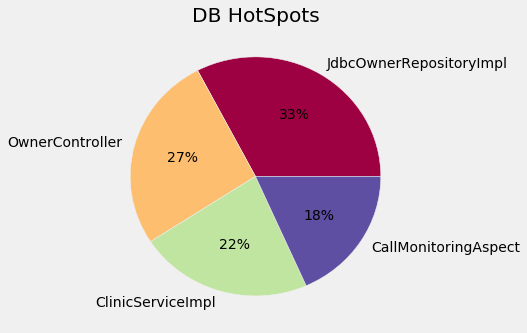

In [12]:
ax = data['sql_count'].plot(
    kind='pie', 
    colors=cm.Spectral(np.linspace(0, 1, len(data))), 
    figsize=(5,5), 
    legend=None, 
    autopct='%1.0f%%',
    title="DB HotSpots")
ax.set_ylabel("")


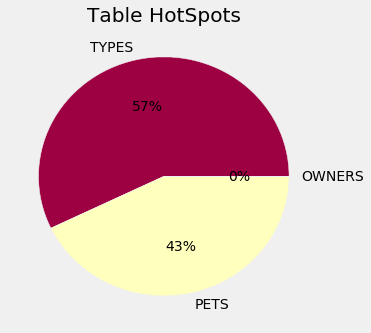

In [13]:
data = hotspots.groupby('table').\
    sum().sort_values(by='sql_count', ascending=False)[['sql_count']].head(10)

ax = data['sql_count'].plot(
    kind='pie', 
    colors=cm.Spectral(np.linspace(0, 1, len(data))), 
    figsize=(5,5), 
    legend=None, 
    autopct='%1.0f%%',
    title="Table HotSpots")
ax.set_ylabel("")

In [14]:
grouped_by_entry_class_and_table = hotspots.groupby(['entry_class', 'table']).\
    sum().sort_values(by='sql_count', ascending=False)[['sql_count']]
grouped_by_entry_class_and_table.head()

,,sql_count
entry_class,table,
JdbcOwnerRepositoryImpl,TYPES,22100.0
OwnerController,TYPES,15470.0
ClinicServiceImpl,TYPES,13260.0
JdbcOwnerRepositoryImpl,PETS,13260.0
OwnerController,PETS,13260.0


In [15]:
from bokeh.charts import Donut, show, output_notebook
from bokeh.charts.utils import df_from_json
from bokeh.sampledata.olympics2014 import data
plot_data = grouped_by_entry_class_and_table.reset_index()
d = Donut(plot_data, label=['entry_class', 'table'], 
          values='sql_count',
          text_font_size='8pt',
          hover_text='sql_count'
         )
output_notebook()
show(d)

Loading BokehJS ...

# Limitations

* There is one big problem with this approach if you use want to export big hotspot call trees in JProfiler. It simply doesn't work because the XML data is getting to big. 
  * One approach would be the get direct access to the HotSpot data in JProfiler. I still have to ask the developers of JProfiler if this would be possible.
  * The other approach that we're trying to do is to export just the Call Tree (because it's not so much data) as XML file, import it into Neo4j (by using jQAssistant, too) and calculate the HotSpots ourself.
* Additionally, jQAssistant / Neo4j wouldn't be able to read hugh (> 2 GB) XML data (with the means we use today)
* Working with huge graphs is a little bit tricky with the embedded Neo4j database that jQAssistant brings 

# Summary
With this approach, you can mine your way through any graph based data format like XML files or other software structures.

The key idea is to load a hugh graph with all the information and just use specific nodes of such a graph for extracting the information needed.